# TD2 : Estimation du coeffcient de Hurst.

* Le but de ce TP est d'éstimer le coeffcient de $\textbf{Hurst}$ dans un premier temps à l'aide d'une $\underline{Architecture \ Dense}$ puis d'une $\underline{Architecture \ Convolutionnel}$ et de déterminer quelle est la meilleur méthode.

* Une autre approche est d'utiliser les $\underline{Wavelets}$.

In [ ]:
!pip3 install --upgrade tensorflow-gpu
!pip3 install fbm
import tensorflow as tf
tf.test.gpu_device_name()

Requirement already up-to-date: tensorflow-gpu in /usr/local/lib/python3.7/dist-packages (2.4.1)


'/device:GPU:0'

In [ ]:
from rpy2 .robjects.packages import importr
utils = importr ('utils')
utils.install_packages ('liftLRD')
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
liftLRD=importr('liftLRD')

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/liftLRD_1.0-8.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 9460 bytes

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to consol

In [ ]:
import time
import pandas as pd
import numpy as np
from fbm import FBM
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense ,Dropout , ELU ,PReLU
from keras.activations import selu
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.utils.vis_utils import plot_model

## Génération des Datasets d'entrainement.

* On génére pour 10 valeurs de $H \in [H_{min},H_{max}]  ⊆ [0,1] $ , $10000$ séries temporelles de longueur $T=100$.On utlise c'est 10000 séries comme $\underline{Dataset \ d'entrainement}$.

* On génére pour 100 valeurs de $H \in [H_{min},H_{max}]  ⊆ [0,1] $ , $1000$ séries temporelles de longueur $T=100$.On utlise c'est 1000 séries comme $\underline{Dataset \ de \ Test}$.


* Ces series temporelles sont des mouvements browniens fractionnaires de coefficients de Hurst H. 

$\textbf{MB Fractionnaire : }$

- Pour un coefficient de Hurst $\underline{inférieur}$ à  $\frac{1}{2}$ le processus est d'autant plus mean reverting que H est petit tout en restant positif.

- Pour une coefficient de Hurst de $\frac{1}{2}$ le Mouvement Brownien fractionnaire est un mouvemement bownien standart. 

- Pour un coefficient de Hurst $\underline{supérieur}$ à  $\frac{1}{2}$ le processus à une tendance de plus en plus marquée quand H augmente en restant inférieur à 1.



In [ ]:
def generate_fbm_set(n_samples,H,T):
  FBmotion = np.zeros((n_samples,T+1))
  f = FBM(n=T, hurst=H)
  for i in range(n_samples):
    FBmotion[i,:] = f.fbm()
  return pd.DataFrame(FBmotion.reshape((FBmotion.shape[0],FBmotion.shape[1])))

def generate_dataset(H_seq,n_samples,T):
  X = pd.DataFrame()
  Y = pd.DataFrame()
  for l in tqdm(list(H_seq)):
    X = pd.concat([X,generate_fbm_set(n_samples,l,T)],axis=0)
    Y = pd.concat([Y,pd.DataFrame(np.repeat(l,n_samples))],axis=0)
  return np.array(X) , np.array(Y)

In [ ]:
H_seq_10 = np.linspace(0.01,0.99,10) ; 
H_seq_100 = np.linspace(0.01,0.99,100) ; 
T = 100 ; n_samples_train = 10000 ; n_samples_test = 1000

X_train , Y_train = generate_dataset(H_seq_10,n_samples_train,T)
X_test , Y_test = generate_dataset(H_seq_100,n_samples_test,T)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


/usr/local/lib/python3.7/dist-packages/fbm/fbm.py:172: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method. Occurs when n is small and Hurst is close to 1. 
  "Combination of increments n and Hurst value H "


##  Estimation à l'aide de Réseaux Denses. 

> $\textbf{Objectif}$ : On cherche à estimer le coefficent de Hurst à l'aide d'un architecture Dense. Nous utilisons donc des réseaux  denses profonds c'est à dire avec plusieurs couches cachées pour avoir le plus de chance de fitter au mieux le coefficient.

- Nous avons choisit d'utiliser deux types de fonctions d'activation pour se reseau aprés avoir testeé de noombresues combinaisons. 

- Nous avons chosit d'utiliser des fonction d'activation "Parametrique Relu" , "tanh" et en sortie une fonction "Sigmoid".

- Nous avons aussi essayé différents algorithmes d'optimisation pour vérifier quel est celui qui obtient le meilleur minimmum local.Nous avons obtenu que "Adam" est le plus éfficace dans notre cas.

Concernant le Early Stopping nous avons bien spécifié que le CallBack se fait sur la "Val_Loss" c'est à dire sur la fonction de perte de l'échantillon de crossvalidation.De plus nous avons specifier de restaurer les meilleurs poids obtenues pour que le modèle renvoyé à l'entrainement soit bein celui qui a minimisé la loss sur l'échantillon cross validé.

In [ ]:
activ = 'relu' ; activ2 = 'tanh'

model = Sequential( )
model.add (Dense(X_train.shape[1],input_dim = X_train.shape[1],activation= activ))
model.add ( Dense (200 ,activation= activ ) )
model.add(PReLU())
model.add ( Dense (200 ,activation= activ2 ) )
model.add ( Dense (150 ,activation= activ ) )
model.add(PReLU())
model.add ( Dense (150 ,activation= activ2 ) )
model.add ( Dense (100 ,activation= activ ) )
model.add(PReLU())
model.add ( Dense (100 ,activation= activ2 ) )
model.add ( Dense (80 ,activation= activ ) )
model.add(PReLU())
model.add ( Dense (80 ,activation= activ2 ) )
model.add ( Dense (40 , activation= activ ) )
model.add(PReLU())
model.add ( Dense (40 , activation= activ2 ) )
model.add ( Dense (10 , activation= activ ) )
model.add(PReLU())
model.add ( Dense (10 , activation= activ2 ) )
model.add ( Dense (5 , activation= activ ) )
model.add(PReLU())
model.add ( Dense (5 , activation= activ2 ) )
model.add ( Dense (1 , activation= 'sigmoid') )


model.compile( loss='mse' , optimizer='adam', metrics=['mse','mae'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,mode='auto', baseline=None,
                                            restore_best_weights=True)
model.fit(X_train,Y_train,validation_split=0.2,epochs=1000, callbacks=[callback])

Epoch 1/1000
2500/2500 [==============================] - 11s 4ms/step - loss: 0.0085 - mse: 0.0085 - mae: 0.0673 - val_loss: 0.0422 - val_mse: 0.0422 - val_mae: 0.1945
Epoch 2/1000
2500/2500 [==============================] - 9s 4ms/step - loss: 0.0024 - mse: 0.0024 - mae: 0.0359 - val_loss: 0.0380 - val_mse: 0.0380 - val_mae: 0.1866
Epoch 3/1000
2500/2500 [==============================] - 9s 4ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0320 - val_loss: 0.0352 - val_mse: 0.0352 - val_mae: 0.1784
Epoch 4/1000
2500/2500 [==============================] - 9s 4ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0301 - val_loss: 0.0365 - val_mse: 0.0365 - val_mae: 0.1818
Epoch 5/1000
2500/2500 [==============================] - 9s 4ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0282 - val_loss: 0.0405 - val_mse: 0.0405 - val_mae: 0.1910
Epoch 6/1000
2500/2500 [==============================] - 10s 4ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0274 - val_loss: 0.0444 - val_mse: 0.0444 - val_ma

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 101)               10302     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20400     
_________________________________________________________________
p_re_lu (PReLU)              (None, 200)               200       
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 150)               30150     
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 150)               150       
_________________________________________________________________
dense_4 (Dense)              (None, 150)               2

In [ ]:
print(f"le nombre total de parametres dans le model est de : {model.count_params()}")

le nombre total de parametres dans le model est de : 169538


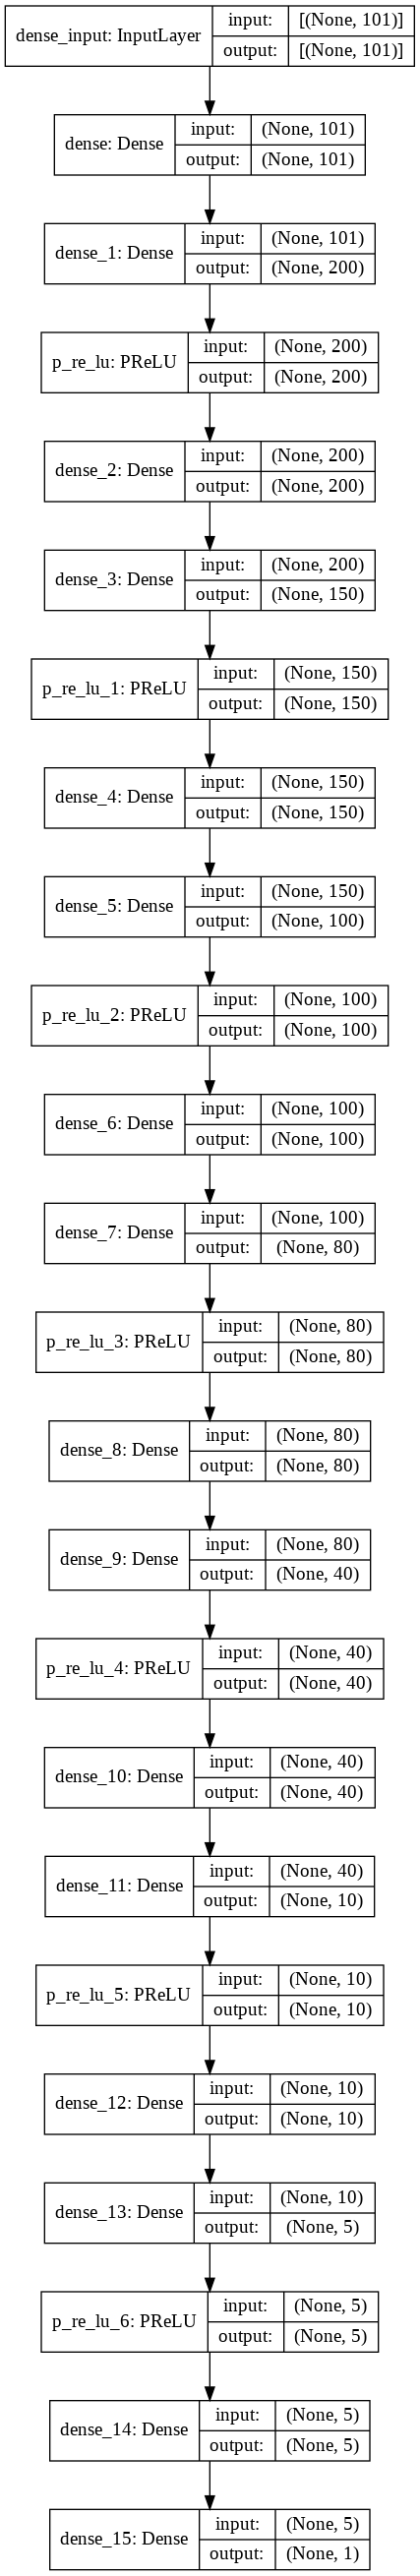

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
Pred = model.predict(X_test)
Results = pd.DataFrame({'Prediction' : list(map(np.float,Pred)) , 'Label' : list(map(np.float,Y_test))})
Results['bias'] = Results['Label'] - Results['Prediction']
Results

,Prediction,Label,bias
0,0.017320,0.01,-0.007320
1,0.017319,0.01,-0.007319
2,0.017316,0.01,-0.007316
3,0.017315,0.01,-0.007315
4,0.017322,0.01,-0.007322
...,...,...,...
99995,0.772842,0.99,0.217158
99996,0.772948,0.99,0.217052
99997,0.741342,0.99,0.248658
99998,0.772946,0.99,0.217054


> $\textbf{Résultats}$ : On trace les graphiques du $\underline{biais \ moyen}$ et de l'erreur moyenne.Pour l'erreur moyenne , nous avons décidé de tracer l'$\underline{erreur\  moyenne \  quadratique}$ et l'$\underline{erreur \ moyenne \ absolue}$.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


No handles with labels found to put in legend.


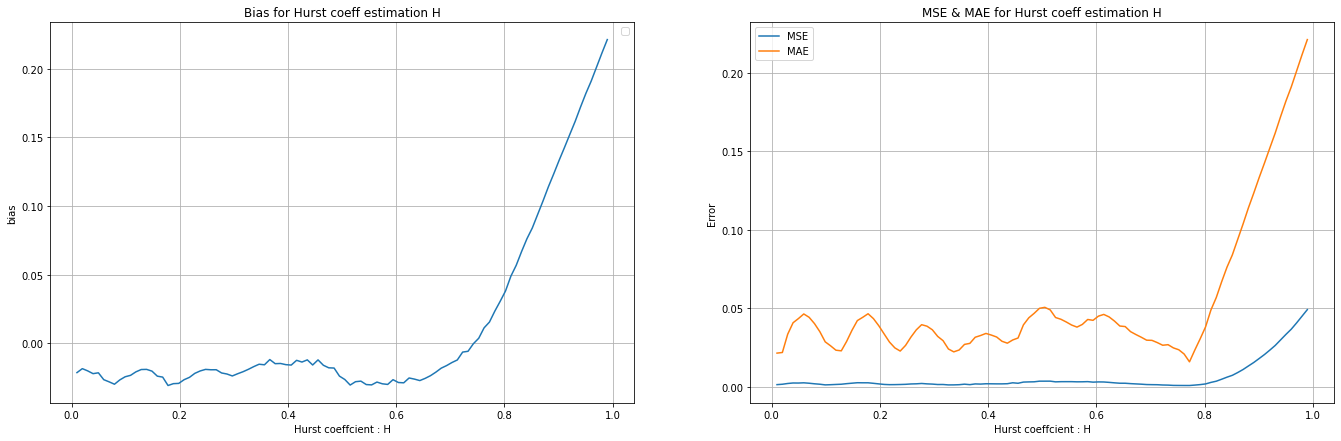

In [ ]:
Bias_DNN = Results.groupby(by=["Label"]).mean()['bias']
MSE_DNN = [] ; MAE_DNN = [] ;
for H_i in tqdm(np.unique(Results.Label.values)):
    err_tab = Results[Results['Label'] == H_i]
    MSE_DNN.append(mean_squared_error(err_tab['Prediction'],err_tab['Label']))
    MAE_DNN.append(mean_absolute_error(err_tab['Prediction'],err_tab['Label']))
###### Graph du Biais , MSE et MAE
fig,axs = plt.subplots(1,2,figsize = (23,7))
axs[0].plot(Results.groupby(by=["Label"]).mean()['bias'])    
axs[0].set_xlabel('Hurst coeffcient : H') ; axs[0].set_ylabel('bias')
axs[0].set_title(f"Bias for Hurst coeff estimation H") ; axs[0].legend() ; axs[0].grid(b=True)
axs[1].plot(np.unique(Results.Label.values),MSE_DNN,label = 'MSE')
axs[1].plot(np.unique(Results.Label.values),MAE_DNN,label = 'MAE')        
axs[1].set_xlabel('Hurst coeffcient : H') ; axs[1].set_ylabel('Error')
axs[1].set_title(f"MSE & MAE for Hurst coeff estimation H") ; axs[1].legend() ; axs[1].grid(b=True)

- On identifie les mêmes phenomenes qu'au TP1 ou le reseaux a du mal à estimer des parametres sur des intervalles de valuers qu'il n 'a pas appris.

- Le reseaux à été entrainé à estimer le coeffcient de Hurst sur des valeurs de allant de 0.1 à 0.9.On observe qu'entre 0.1 et 0.7 l'estimation est de bonne qualité. Cepedant quand nous etudions les valeurs entre sur l'intervalle $]0,1[$ on observe que plus on se rapproche de 0 plus le biais est important. Ceci est du au fait que les se sont des valeurs que le reseaux n'a pas apprit, il a donc du mal à les éstimer correctement.

- D'autre part on observe qu'il n'y a pas de symétrie parfaite que se soit sur le biais moyen ou l'érreur moyenne.En effet le réseau à beaucoup de mal à donner des estimateurs de bonne qualitée pour des valeurs de H au dela de 0.7.



## Estimation à l'aide de Réseaux Convolutionnels

> $\textbf{Objectif}$ : On cherche à estimer le coefficent de Hurst à l'aide d'un architecture Convolutionnel. Nous utilisons donc des réseaux  denses profonds c'est à dire avec plusieurs couches cachées pour avoir le plus de chance de fitter au mieux le coefficient.

In [ ]:
X_train_cnn = np.expand_dims(X_train, axis=2);
X_train_cnn.shape

(100000, 101, 1)

In [ ]:
from keras.layers import Dense, Conv1D, Flatten , MaxPooling1D , Dropout
from keras.layers.advanced_activations import LeakyReLU

leaky_relu_alpha = 0.1
n_timesteps, n_features, n_outputs = X_train_cnn.shape[1], X_train_cnn.shape[2], Y_train.shape[1]

model = Sequential()
model.add(Conv1D(filters=32,kernel_size=20, activation='linear',padding='same', input_shape=(n_timesteps,n_features)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D(pool_size=3 , padding='same'))
model.add(Dropout(0.25))
model.add(Conv1D(filters=64,kernel_size=20,activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D(pool_size=3 , padding='same'))
model.add(Dropout(0.25))
model.add(Conv1D(filters=128,kernel_size=20,activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D(pool_size=3 , padding='same'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128 ,activation='linear'))
model.add(LeakyReLU(alpha=0.1))   
model.add(Dropout(0.3))
model.add(Dense(n_outputs, activation='sigmoid'))

model.compile( loss=keras.losses.mean_squared_error , optimizer='adam', metrics=['mse','mae'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,mode='auto', baseline=None,
                                            restore_best_weights=True)

In [ ]:
model.fit(X_train_cnn,Y_train,validation_split=0.2,epochs=1000, batch_size=32, callbacks=[callback])

Epoch 1/1000
2500/2500 [==============================] - 11s 4ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0352 - val_loss: 0.0172 - val_mse: 0.0172 - val_mae: 0.1210
Epoch 2/1000
2500/2500 [==============================] - 8s 3ms/step - loss: 8.0774e-04 - mse: 8.0774e-04 - mae: 0.0220 - val_loss: 0.0239 - val_mse: 0.0239 - val_mae: 0.1462
Epoch 3/1000
2500/2500 [==============================] - 8s 3ms/step - loss: 7.3869e-04 - mse: 7.3869e-04 - mae: 0.0209 - val_loss: 0.0266 - val_mse: 0.0266 - val_mae: 0.1545
Epoch 4/1000
2500/2500 [==============================] - 9s 3ms/step - loss: 6.7005e-04 - mse: 6.7005e-04 - mae: 0.0199 - val_loss: 0.0220 - val_mse: 0.0220 - val_mae: 0.1386


In [ ]:
X_test_cnn = np.expand_dims(X_test, axis=2);
Pred = model.predict(X_test_cnn);
Results = pd.DataFrame({'Prediction' : list(map(np.float,Pred)) , 'Label' : list(map(np.float,Y_test))});
Results['bias'] = Results['Label'] - Results['Prediction']; Results ;

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


No handles with labels found to put in legend.


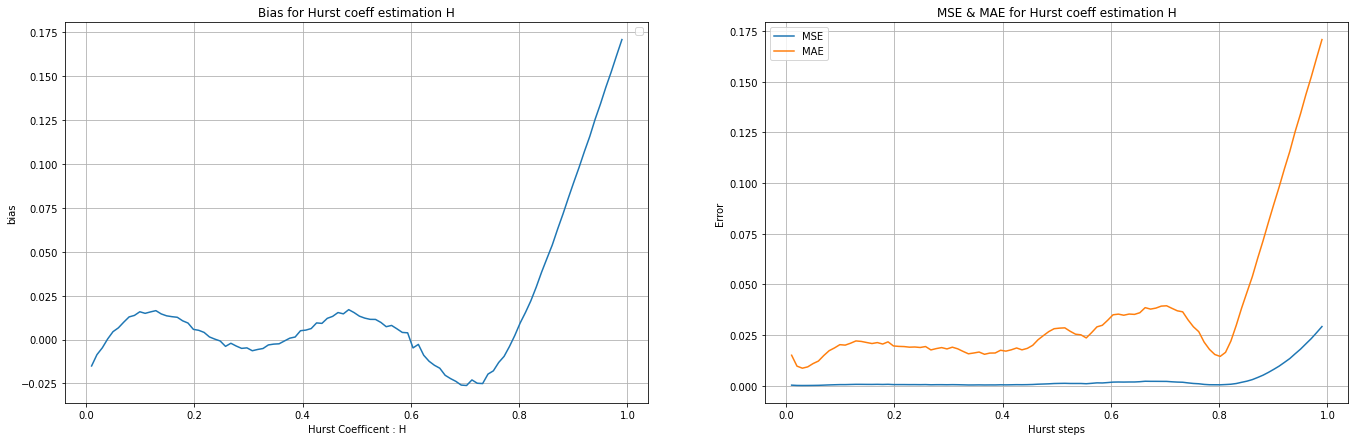

In [ ]:
Bias_CNN = Results.groupby(by=["Label"]).mean()['bias']
MSE_CNN = [] ; MAE_CNN = [] ;
for H_i in tqdm(np.unique(Results.Label.values)):
    err_tab = Results[Results['Label'] == H_i]
    MSE_CNN.append(mean_squared_error(err_tab['Prediction'],err_tab['Label']))
    MAE_CNN.append(mean_absolute_error(err_tab['Prediction'],err_tab['Label']))


###### Graph du Biais , du MSE et MAE
fig,axs = plt.subplots(1,2,figsize = (23,7))
axs[0].plot(Results.groupby(by=["Label"]).mean()['bias'])    
axs[0].set_xlabel('Hurst Coefficent : H') ; axs[0].set_ylabel('bias')
axs[0].set_title(f"Bias for Hurst coeff estimation H") ; axs[0].legend() ; axs[0].grid(b=True)
axs[1].plot(np.unique(Results.Label.values),MSE_CNN,label = 'MSE')
axs[1].plot(np.unique(Results.Label.values),MAE_CNN,label = 'MAE')        
axs[1].set_xlabel('Hurst steps') ; axs[1].set_ylabel('Error')
axs[1].set_title(f"MSE & MAE for Hurst coeff estimation H") ; axs[1].legend() ; axs[1].grid(b=True)

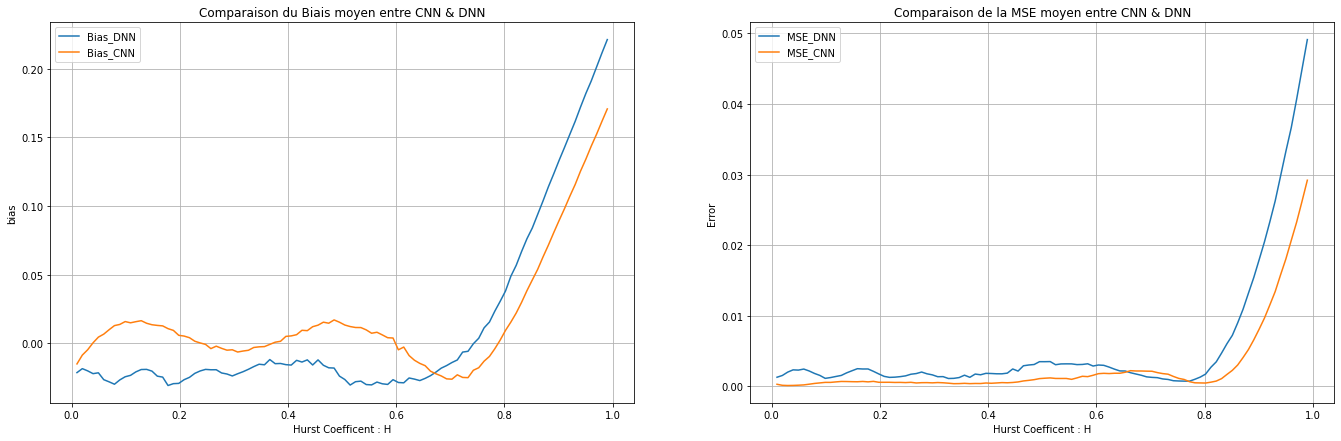

In [ ]:
###### Graph du Biais , du MSE et MAE
fig,axs = plt.subplots(1,2,figsize = (23,7))
axs[0].plot(Bias_DNN,label = 'Bias_DNN')
axs[0].plot(Bias_CNN,label = 'Bias_CNN')    
axs[0].set_xlabel('Hurst Coefficent : H') ; axs[0].set_ylabel('bias')
axs[0].set_title(f"Comparaison du Biais moyen entre CNN & DNN") ; axs[0].legend() ; axs[0].grid(b=True)
axs[1].plot(np.unique(Results.Label.values),MSE_DNN,label = 'MSE_DNN')  
axs[1].plot(np.unique(Results.Label.values),MSE_CNN,label = 'MSE_CNN')    
axs[1].set_xlabel('Hurst Coefficent : H') ; axs[1].set_ylabel('Error')
axs[1].set_title(f"Comparaison de la MSE moyen entre CNN & DNN") ; axs[1].legend() ; axs[1].grid(b=True)

## Estimation du Coefficient de Hurst basée sur la Transformée par ondelette.

> $\textbf{Objectif}$ : On cherche à estimer le coefficent de Hurst à l'aide d'une methode de transformée par ondelette. 

Le Mouvement Brownien Fractionnaire $ X(t)$ ,$t \in \mathbb{R}$ de coefficient de Hurst $H > 0$ est un processus réel Gaussian centré nul en zéro et continu,suivant une structure de covariance de la forme:

$$ E(X_{s}X_{t}) = \frac{1}{2}(|t|^{2H} + |s|^{2H} - |t-s|^{2H})$$




Nous utilisons dans se TP le package liftLRD de R qui correspond à l'abréviation de "Wavelet lifting estimators of the Hurst exponent for regularly and irregularly sampled time series".

La methode implementée dans cette library se basent sur la publication de $ \textit{Marina  I.Knight}$ ,$\textit{Guy P. Nason}$ et $\textit{Matthew A. Nunes}$ :

- $\textit{" A wavelet lifting approach to long-memory estimation"}$.


Nous allons énoncé dans les grandes ligne les etapes de cette méthodes pour comprendre quels avantages et quelles limites elle présente.

Time series that arise in many fields often display
persistent (slow power-law decaying) autocorrelations even
over large lags. This phenomenon is known as long memory
or long-range dependence. Remarkably, the degree of persistence can be quantified by means of a single parameter,
known in the literature as the Hurst parameter.

In [ ]:
outpouts_wavelets = pd.DataFrame() ; 
for j in tqdm(range(len(H_seq_100))) : 
  for i in tqdm(range(50)):
    beta , H_hat , sds , lower ,  upper = liftLRD.liftHurst(np.diff(X_test[int(j*1000 + i),:]))[0]
    outpouts_wavelets = outpouts_wavelets.append({'H_label': H_seq_100[j],'beta' : beta ,'H_hat' : H_hat , 'sds' : sds , 'lower' : lower , 'upper' : upper} , ignore_index=True)


> Run les wavelets sur seulement 50 samples pour chaque valeurs de H.Le temps d'execution est de 1h30.Nous avons dans un premier temps lancé sur des echantillons de 100 pour chaque valeur de H mais nous avons fait face à un temps de calcul trops important.

In [ ]:
outpouts_wavelets

In [ ]:
outpouts_wavelets['bias'] = outpouts_wavelets['H_label'] - outpouts_wavelets['H_hat']
outpouts_wavelets

In [ ]:
Bias_Wavelets = outpouts_wavelets.groupby(by=["H_label"]).mean()['bias']
MSE_Wavelets = [] ; MAE_Wavelets = [] ;
for H_i in tqdm(np.unique(outpouts_wavelets.H_label.values)):
    err_tab = outpouts_wavelets[outpouts_wavelets['H_label'] == H_i]
    MAE_Wavelets.append(mean_squared_error(err_tab['H_hat'],err_tab['H_label']))
    MSE_Wavelets.append(mean_absolute_error(err_tab['H_hat'],err_tab['H_label']))


###### Graph du Biais , du MSE et MAE
fig,axs = plt.subplots(1,2,figsize = (23,7))
axs[0].plot(outpouts_wavelets.groupby(by=["H_label"]).mean()['bias'])    
axs[0].set_xlabel('Hurst Coefficent : H') ; axs[0].set_ylabel('bias')
axs[0].set_title(f"Bias for Hurst coeff estimation H") ; axs[0].legend() ; axs[0].grid(b=True)
axs[1].plot(np.unique(outpouts_wavelets.H_label.values),MSE_Wavelets,label = 'MSE')
axs[1].plot(np.unique(outpouts_wavelets.H_label.values),MAE_Wavelets,label = 'MAE')        
axs[1].set_xlabel('Hurst steps') ; axs[1].set_ylabel('Error')
axs[1].set_title(f"MSE & MAE for Hurst coeff estimation H") ; axs[1].legend() ; axs[1].grid(b=True)

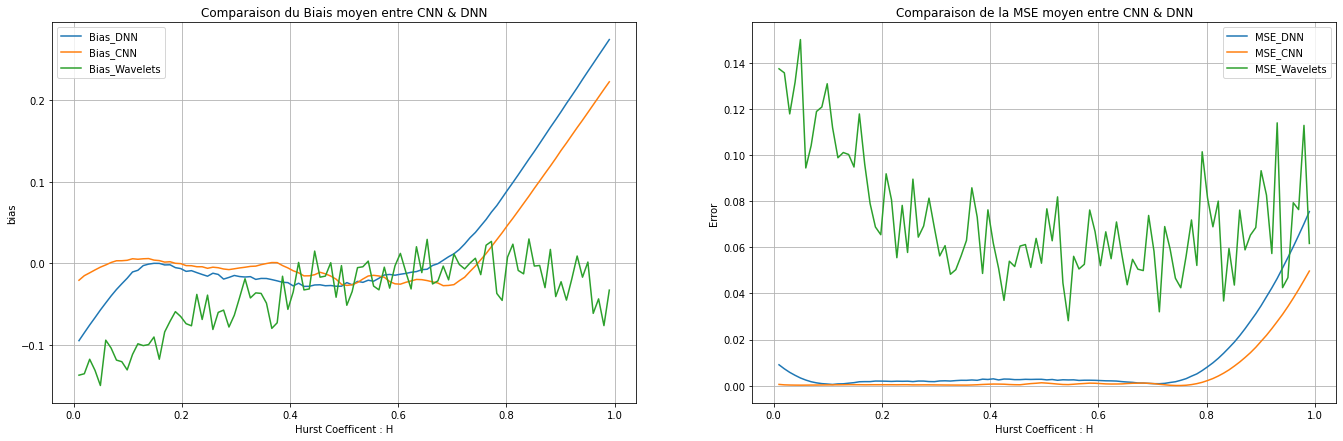

In [ ]:
###### Graph du Biais , du MSE et MAE
fig,axs = plt.subplots(1,2,figsize = (23,7))
axs[0].plot(Bias_DNN,label = 'Bias_DNN')
axs[0].plot(Bias_CNN,label = 'Bias_CNN')
axs[0].plot(Bias_Wavelets,label = 'Bias_Wavelets')     
axs[0].set_xlabel('Hurst Coefficent : H') ; axs[0].set_ylabel('bias')
axs[0].set_title(f"Comparaison du Biais moyen entre CNN & DNN") ; axs[0].legend() ; axs[0].grid(b=True)
axs[1].plot(np.unique(Results.Label.values),MSE_DNN,label = 'MSE_DNN')  
axs[1].plot(np.unique(Results.Label.values),MSE_CNN,label = 'MSE_CNN')
axs[1].plot(np.unique(outpouts_wavelets.H_label.values),MSE_Wavelets,label = 'MSE_Wavelets')   
axs[1].set_xlabel('Hurst Coefficent : H') ; axs[1].set_ylabel('Error')
axs[1].set_title(f"Comparaison de la MSE moyen entre CNN & DNN") ; axs[1].legend() ; axs[1].grid(b=True)

No handles with labels found to put in legend.


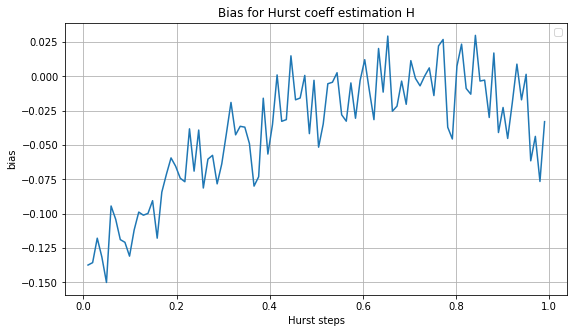

In [ ]:
###### Graph du Biais
fig,ax1 = plt.subplots(1,1,figsize = (9,5))
ax1.plot(outpouts_wavelets.groupby(by=["H_label"]).mean()['bias'])    
ax1.set_xlabel('Hurst steps') ; ax1.set_ylabel('bias')
ax1.set_title(f"Bias for Hurst coeff estimation H") ; ax1.legend() ; ax1.grid(b=True)

In [ ]:
MSE = [] ; MAE = [] ;
for H_i in tqdm(np.unique(Results.Label.values)):
    err_tab = Results[Results['Label'] == H_i]
    MSE.append(mean_squared_error(err_tab['Prediction'],err_tab['Label']))
    MAE.append(mean_absolute_error(err_tab['Prediction'],err_tab['Label']))

###### Graph du MSE et MAE
fig,ax1 = plt.subplots(1,1,figsize = (9,5)) ; 
ax1.plot(np.unique(Results.Label.values),MSE,label = 'MSE') ; 
ax1.plot(np.unique(Results.Label.values),MAE,label = 'MAE')  ;        
ax1.set_xlabel('Hurst steps') ; ax1.set_ylabel('Error') ; 
ax1.set_title(f"MSE & MAE for Hurst coeff estimation H") ; ax1.legend() ; ax1.grid(b=True) ;
ax1.set_title(f"")